In [17]:
# Factorization machine

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# load data
raw_data = np.loadtxt('fm_dataset/fm_dataset.csv', delimiter=',')

# split data into train and test
np.random.seed(0)
ratio = 0.8
split_idx = int(len(raw_data) * ratio)
X_train, y_train = raw_data[:split_idx, :-1], raw_data[:split_idx, -1]
X_test, y_test = raw_data[split_idx:, :-1], raw_data[split_idx:, -1]

# print data info
print('feature: ', X_train.shape[1])
print('train size: ', len(X_train))
print('test size: ', len(X_test))

feature:  24
train size:  800
test size:  200


In [39]:
# create model
class FM(object):
    def __init__(self, feature_num, vector_dim) -> None:
        self.feature_num = feature_num
        self.vector_dim = vector_dim
        self.theta0 = 0.0
        self.theta = np.zeros(feature_num)
        self.v = np.random.normal(size=(feature_num, vector_dim))
        self.eps = 1e-6

    def logistic(self, y):
        return 1 / (1 + np.exp(-y))
    
    def predict(self, X):
        linear_part = self.theta0 + X @ self.theta
        bilinear_part = 0.5 * np.sum(np.square(X @ self.v) 
                                     - np.square(X) @ np.square(self.v), axis=1)
        y_hat = self.logistic(linear_part + bilinear_part)
        y_hat = np.clip(y_hat, self.eps, 1 - self.eps)
        return y_hat
    
    def update(self, X, y_hat, y, learning_rate, lbd):
        difference = (y_hat - y).reshape(-1, 1)
        # update theta0
        grad_0 = np.sum(difference * (1 / len(X) + lbd))
        # update theta
        grad_theta = np.sum(difference * (X / len(X) + lbd * self.theta), axis=0)
        # update v
        grad_v = np.zeros(shape=(self.feature_num, self.vector_dim))
        for i, x in enumerate(X):
            xv = x @ self.v
            grad_vi = np.zeros(shape=(self.feature_num, self.vector_dim))
            for s in range(self.feature_num):
                grad_vi[s] += x[s] * xv - (x[s] ** 2) * self.v[s]
            grad_v += difference[i] * grad_vi
        grad_v = grad_v / len(X) + lbd * self.v
        self.theta0 -= learning_rate * grad_0
        self.theta -= learning_rate * grad_theta
        self.v -= learning_rate * grad_v

In [40]:
# hyper parameters
feature_number = X_train.shape[1]
vector_dimension = 16
learning_rate = 0.01
lbd = 0.05
n_epochs = 170
batch_size = 32

np.random.seed(1)
fm = FM(feature_number, vector_dimension)

# evaluation
train_acc = []
test_acc = []
train_auc = []
test_auc = []

for epoch in range(n_epochs):
    start = 0
    while(start < len(X_train)):
        end = min(start + batch_size, len(X_train))
        X = X_train[start : end]
        y = y_train[start : end]
        start += batch_size
        # predict
        y_hat = fm.predict(X)
        # loss
        loss = np.sum(-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat))
        # optimize
        fm.update(X, y_hat, y, learning_rate, lbd)
    # evaluate
    y_train_pred = (fm.predict(X_train) >= 0.5)
    acc = np.mean(y_train_pred == y_train)
    train_acc.append(acc)
    auc = metrics.roc_auc_score(y_train, y_train_pred)
    train_auc.append(auc)

    y_test_pred = (fm.predict(X_test) >= 0.5)
    acc = np.mean(y_test == y_test_pred)
    test_acc.append(acc)
    auc = metrics.roc_auc_score(y_test, y_test_pred)
    test_auc.append(auc)

print(f"train accuracy: {train_acc[-1]}, train AUC: {train_auc[-1]}")
print(f"test accuracy: {test_acc[-1]}, test AUC: {test_auc[-1]}")

# 1.train accuracy: 0.80375, train AUC: 0.7279849939214941
#   test accuracy: 0.75, test AUC: 0.6867555136218895

train accuracy: 0.815, train AUC: 0.7396087381319967
test accuracy: 0.795, test AUC: 0.723729213350631


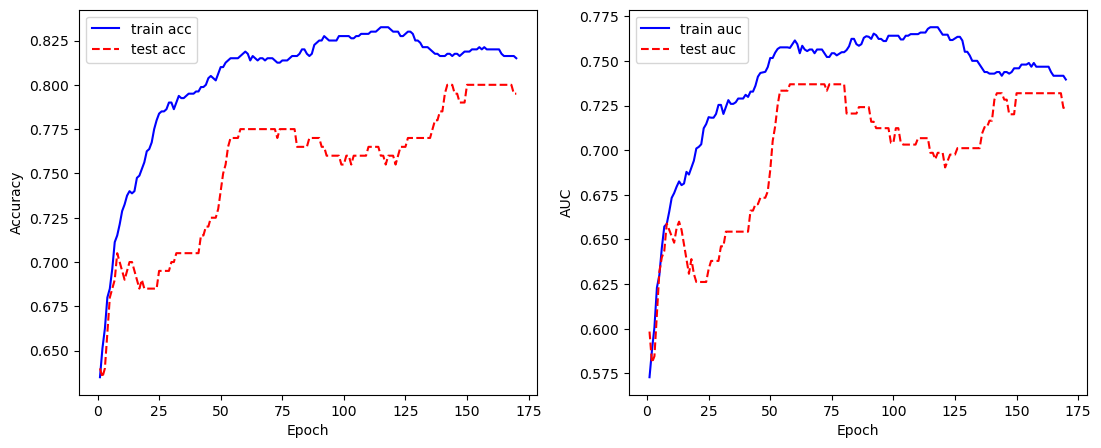

In [41]:
# visualize the acc and auc curve
plt.figure(figsize=(13, 5))
x_range = np.arange(len(train_acc)) + 1

plt.subplot(121)
plt.plot(x_range, 
         train_acc, 
         color='blue', 
         label='train acc')
plt.plot(x_range, 
         test_acc, 
         color='red',
         ls = '--', 
         label='test acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(x_range, 
         train_auc, 
         color='blue', 
         label='train auc')
plt.plot(x_range, 
         test_auc, 
         color='red',
         ls = '--', 
         label='test auc')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.show()